2025-11-14 16:26:32.938317: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-14 16:26:34.648153: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Episode:   0 | Score:  16 | Epsilon: 1.000
Episode:   1 | Score:  25 | Epsilon: 1.000
Episode:   2 | Score:  13 | Epsilon: 1.000
Episode:   3 | Score:  13 | Epsilon: 0.980
Episode:   4 | Score:  16 | Epsilon: 0.905
Episode:   5 | Score:  11 | Epsilon: 0.856
Episode:   6 | Score:  12 | Epsilon: 0.806
Episode:   7 | Score:  21 | Epsilon: 0.726
Episode:   8 | Score:  12 | Epsilon: 0.683
Episode:   9 | Score:  16 | Epsilon: 0.631
Episode:  10 | Score:  13 | Epsilon: 0.591
Episode:  11 | Score:  12 | Epsilon: 0.556
Episode:  12 | Score:  15 | Epsilon: 0.516
Episode:  13 | Score:  10 | Epsilon: 0.491
Episode:  14 | Score:   9 | Epsilon: 0.469
Episode:  15 | Score:   9 | Epsilon: 0.448
Episode:  16 | Score:  11 | Epsilon: 0.424
Episode:  17 | Score:  11 | Epsilon: 0.402
Episode:  18 | Score:   9 | Epsilon: 0.384
Episode:  19 | Score:  10 | Epsilon: 0.365
Episode:  20 | Score:  15 | Epsilon: 0.339
Episode:  21 | Score:  10 | Epsilon: 0.322
Episode:  22 | Score:  27 | Epsilon: 0.281
Episode:  2

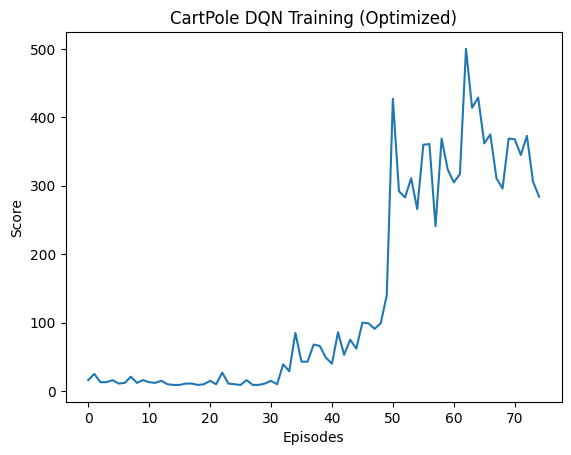

In [1]:
import random
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Disable TensorFlow logs for cleaner output
tf.get_logger().setLevel('ERROR')

EPISODES = 100

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Input(shape=(self.state_size,)),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def save(self, filename):
        # Keras 3 requires .weights.h5 extension for save_weights
        if not filename.endswith(".weights.h5"):
            filename += ".weights.h5"
        self.model.save_weights(filename)

    def load(self, filename):
        if not filename.endswith(".weights.h5"):
            filename += ".weights.h5"
        self.model.load_weights(filename)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i, (s, a, r, s2, d) in enumerate(minibatch):
            states[i] = s
            next_states[i] = s2
            actions.append(a)
            rewards.append(r)
            dones.append(d)

        # Batch predictions (fast)
        target = self.model.predict(states, verbose=0)
        target_next = self.model.predict(next_states, verbose=0)

        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.gamma * np.max(target_next[i])

        self.model.fit(states, target, batch_size=self.batch_size, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# ---------------- MAIN ---------------- #
if __name__ == "__main__":
    env = gym.make("CartPole-v1")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    scores = []
    episodes = []

    for e in range(EPISODES):
        state, _ = env.reset()
        state = np.reshape(state, [1, state_size])
        done = False
        t = 0

        while not done:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            reward = reward if not done else -10
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            t += 1

            agent.replay()  # train every step

        print(f"Episode: {e:3d} | Score: {t:3d} | Epsilon: {agent.epsilon:.3f}")
        scores.append(t)
        episodes.append(e)

        # Early stopping if solved
        if np.mean(scores[-50:]) >= 195:
            print(f"Solved in {e} episodes.")
            break

    agent.save("cartpole_dqn_fast.weights.h5")

    plt.plot(episodes, scores)
    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.title("CartPole DQN Training (Optimized)")
    plt.show()